# TP3 Reconstruction of DOSY NMR signals - Part II

## Maximum entropy regularization

### 1. Is ent convex ? proper ? lower-semicontinuous ? differentiable ?


* **Lower-semicontinuous**

$\varphi$ is continuous on $\mathbb{R}^+$ and for all sequence $(u_n)$ such that $u_n \underset{n \rightarrow +\infty}\rightarrow 0$, $~\underset{n \rightarrow +\infty}{\text{lim inf}}f(u_n)= + \infty \geq 0 = f(0)$. Thus $\varphi$ is l.s.c. and finally $ent$ is l.s.c. as a sum of l.s.c. functions.

* **Proper**

$ent$ is proper since $ent(0) = 0< +\infty$ and $ent(x) \neq - \infty$ $\forall x\in \mathbb{R}$.

* **Differentiable**

$\varphi$ is clearly differentiable on $\mathbb{R}^+_*$ and so $ent$ is differentiable on $(\mathbb{R}^+_*)^n$. However $\varphi$ is not differentiable in 0 since $\varphi'(u) = \log(u) +1 \underset{u \rightarrow 0}{\longrightarrow} -\infty$. Hence we can not make the differentiation domain of $ent$ larger than $(\mathbb{R}^+_*)^n$.

* **Convex**

For all $u\in \mathbb{R}^+_*$, $\varphi''(u) = \frac{1}{u} >0$ so $\varphi$ is (strictly) convex on $\mathbb{R}^+$. Thus $ent$ is (strictly) convex on $(\mathbb{R}^+)^n$ as a sum of convex functions.

### 2. Has the optimization problem a solution ? Is it unique ?


Let $h(x) =  \frac{1}{2} \Vert Kx -y\Vert^2 + \beta~ ent(x)$.
* **Existence.**
$h$ is l.s.c, proper and coercive so $h$ admits a minimum and this minimum lies in $(\mathbb{R}^+)^n$.

* **Uniqueness.**
$ent$ is strictly convex on $(\mathbb{R}^+)^n$ and $x \mapsto  \Vert Kx -y\Vert^2$ is convex so $h$ is stricly convex on $(\mathbb{R}^+)^n$. Therefore, the minimum on $(\mathbb{R}^+)^n$ is unique.



### 3. Give the expression of the proximity operator of ent at some x ∈ R

Let us first compute the proximity operator of $\gamma\varphi$, for $\gamma >0$. 

\begin{align*}
\text{prox}_{\varphi}(u) &= \underset{y\in \mathbb{R}}{\text{argmin}}~ \gamma \varphi(y) + \frac{1}{2}\Vert u-y \Vert^2 \\
&= \underset{y\in \mathbb{R}^+}{\text{argmin}}~ \gamma y \log(y) + \frac{1}{2}\Vert u-y \Vert^2 
\end{align*}

$g_u : y \mapsto \gamma y \log(y) + \frac{1}{2}\Vert u-y \Vert^2 = \gamma y \log(\gamma y) - \gamma y \log(\gamma) + \frac{1}{2}\Vert u-y \Vert^2$ is strictly convex and can be minimized by setting its derivative to zero :
\begin{align*}g_u'(y) =0 &\iff \gamma +\gamma \log(\gamma y) - \gamma \log(\gamma)+ y = u \\ &\iff  \log(\gamma y) + y/\gamma = -1 + \log(\gamma)+ u/\gamma \\ & \iff \gamma y e^{y/\gamma} = e^{-1 + \log(\gamma)+ u/\gamma}
\\ & \iff y = \gamma W \left( e^{-1 - \log(\gamma)+ u/\gamma}\right) \end{align*}

where $W$ is the Lambert function. Finally $\text{prox}_{\gamma\varphi}(u)  =  \gamma W \left( e^{-1 - \log(\gamma)+ u/\gamma}\right)$. 

Let us finally compute the proximity operator of $\gamma~ \text{ent}$. We have $\text{ent} = \sum_{n=1}^N \varphi_n$ where forall $n \in [1, N]$, $\varphi_n(x) = \varphi(x_n) \in \Gamma_0$. Hence $$\boxed{\text{prox}_{\text{ent}}(x) = \left(\gamma W \left( e^{-1 - \log(\gamma)+ x_n/\gamma}\right)\right)_{n\in [1, N]}}$$

### 4. Propose a forward-backward and a Douglas-Rachford algorithm to solve problem

Let $f: x \mapsto \beta \,\text{ent}(x)\in \Gamma_0(\mathbb{R}^N)$ and $g: x \mapsto \frac{1}{2}\left\lVert Kx - y \right\rVert ^2 \in \Gamma_0(\mathbb{R}^N)$.

#### Foward-backward algorithm

The Foward-backward algorithm is adapted to our problem since $f, g \in \Gamma_0$, $g$ is differentiable on $\mathbb{R}^N$ and we know the proximity operator of $\gamma f$:$$\text{prox}_{\gamma f}(x) = \left(\beta\gamma W \left( e^{-1 - \log(\beta\gamma)+ \frac{x_n}{(\beta\gamma)}}\right)\right)_{n\in [1, N]}$$
Let's set the parameters : 

* $\nu$: Lipschitz constant of $\nabla g$.
We have $\nabla g(x) = K^T(Kx-y)$, so the best $\nu$ that can be chosen is $\nu =\Vert K^T K \Vert_2 = \rho (K^T K)$ where $\rho$ is the spectral radius. It can be computed with the package `linalg`.

* $\gamma \in [0, 2/\nu]$ and $\delta = 2 - \gamma \nu /2 \in ]1, 2[$.
* $\lambda_n$ a sequence in $[0, \delta]$. For simplicity we choose $\lambda_n = 0.98\times\delta$ for all $n$.

According to question 2, the condition $\text{Argmin }~(f+g) \neq \emptyset$ is verified. 


#### Douglas-Rachford algorithm

The Douglas-Rachford algorithm is also an adapted solution to our problem since we can compute both $f$ and $g$ proximity operators. Under the asumption that $\gamma K^T K + Id$ is invertible (which stands for $\gamma$ small enough), we have :
$$\text{prox}_{\gamma g} (x) = \left(\gamma K^T K + Id \right)^{-1} \left( x + \gamma K^T y \right)$$
$$\text{prox}_{\gamma f}(x) = \left(\beta\gamma W \left( e^{-1 - \log(\beta\gamma)+ \frac{x_n}{(\beta\gamma)}}\right)\right)_{n\in [1, N]}$$

We set $\lambda_n  =1/2 $ for all $n \in \mathbb{N}$ and $\gamma =1$.



### 5. Implement them both and evaluate their performances for β = 10−2

We first load the data and define the functions $\nabla g$, $\text{prox}_{\gamma f}$, $\text{prox}_{\gamma g}$.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from numpy import exp#, log
from math import log
from scipy import linalg
from scipy.special import lambertw
from tqdm import tqdm

T_MIN = 1
T_MAX = 1000
N = 200
M = 50
t_MIN = 0
t_MAX = 1.5

original_signal = np.loadtxt('x.txt')

def T_sampling(n):
    return T_MIN * exp(-(n-1)*(log(T_MIN/T_MAX)/(N-1)))

T = T_sampling(np.arange(1, N+1))

def t_sampling(m):
    return t_MIN + (m-1)/(M-1) * (t_MAX - t_MIN)
t = t_sampling(np.arange(1, M+1))

K = exp(-np.tensordot(t, T, axes = 0))

z = K @ original_signal
sigma = 0.01 * z[0]
I_M = np.identity(M)
cov = sigma**2 * I_M
mean = np.zeros(M)

w = np.random.multivariate_normal(mean, cov)
y = z + w

K_SQUARE = K.T @ K
KY = K.T @ y

def relative_change(x, x_new):
    return linalg.norm(x_new-x) / linalg.norm(x)

X_BAR_SQUARE = np.dot(original_signal, original_signal)
def normalized_quadratic_error(restored_signal):
    x_hat_square = np.dot(restored_signal, restored_signal)
    return (x_hat_square -2 * np.dot(original_signal, restored_signal) + X_BAR_SQUARE) / X_BAR_SQUARE

MATRIX = K_SQUARE
def grad_g(x):
    '''return gradient of g'''
    return MATRIX @ x - KY
    

def prox_f(gamma, x): # gamma = gamma*beta!
    return gamma * np.real(lambertw(exp(x/gamma -1 - log(gamma))))

ID = np.identity(N)
def prox_g(gamma, x):
    argmin = linalg.solve(gamma*K_SQUARE + ID, x+gamma*KY)
    return argmin


#### Foward-backward algorithm implementation

In [2]:
Y_SQUARE = y @ y

def prox(Chi, ksi):
    """Prox of Chi * norm_1(ksi). Note that ksi could be a vector."""
    return np.sign(ksi) * np.maximum(np.abs(ksi) - Chi, 0)

def Foward_Backward(x_0, eps, beta):  

    # Parameters
    nu = np.max(np.abs(linalg.eigvals(MATRIX)))
    gamma = (2 / nu) * 0.98
    delta = 2 - gamma*nu/2
    
    def line_search(x, prox_y):
        lamb_candidate = np.array([0.01, 0.05, 0.1, 0.2, 0.5, 1])
        Lambda = lamb_candidate * 0.98 * gamma
        Lambda = np.tile(Lambda, (N,1)).T
        X = np.tile(x, (lamb_candidate.size, 1))
        X_candidate = X + Lambda * (prox_y - x)
        f_X_candidate = 1/2 * np.einsum('ij,ji->i', X_candidate @ K_SQUARE, X_candidate.T) 
        f_X_candidate -= X_candidate @ KY 
        f_X_candidate += 1/2*Y_SQUARE 
        f_X_candidate += beta/2 * linalg.norm(X_candidate, ord=1, axis=1) 
        minimum_x = X_candidate[np.argmin(f_X_candidate)]

        return minimum_x

    # Initialisation
    x = x_0
    stopping_criteria = 1
    iteration = 0
    MAX_ITER = 1e5
    
    
    # Itération
    while stopping_criteria > eps :
        if iteration > MAX_ITER:
            print('max iteration {} reached'.format(MAX_ITER))
            return x
        
        iteration += 1
        z = x-gamma*grad_g(x)
        prox_z = prox_f(gamma * beta, z)
        x_new = line_search(x, prox_z)
        
        #print(x)
        stopping_criteria = relative_change(x, x_new)
        x = x_new

        #if iteration%100 == 0:
            #print('iter = {}, err = {}, norme x = {}'.format(iteration,stopping_criteria,np.linalg.norm(x)))
    
    return x

error = 0.00046055 with Foward Backward Algorithm, β=0.02


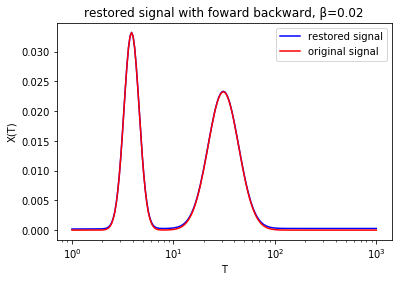

In [3]:
#beta = 1e-02
beta =0.02
x_0 = original_signal
restored_signal_FB = Foward_Backward(x_0, 1e-6, beta)
plt.plot(T, restored_signal_FB, 'b-', label='restored signal')
plt.plot(T, original_signal, 'r-', label='original signal')
plt.title('restored signal with foward backward, \u03B2={}'.format(beta))
plt.legend()
plt.xscale('log')
plt.xlabel('T')
plt.ylabel('X(T)');

error = normalized_quadratic_error(restored_signal_FB)
print('error = {:9.8f} with Foward Backward Algorithm, \u03B2={}'.format(error, beta))


#### Douglas Rachford algorithm implementation

In [4]:
def Douglas_Rachford(x_0, eps, beta):
    
    lamb = 1/2
    gamma = 1
    x = x_0
    MAX_ITER = int(1e6)
    
#     breakpoint()
    for _ in range(MAX_ITER):
        z = prox_g(gamma, x)
        w = prox_f(gamma*beta, 2*z-x)
        x_next = x + lamb * (w - z)
        change_rate = relative_change(x, x_next)
        x = x_next
        if change_rate < eps:
            return x
    return x
            

error = 22.06796630 with Douglas Rachford Algorithm, β=0.01


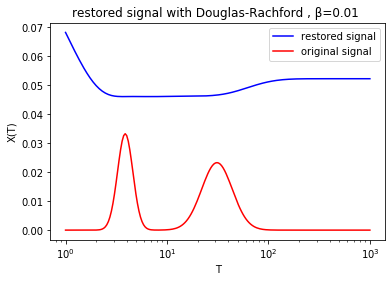

In [5]:
beta =0.01
x_0 = original_signal
restored_signal_DR = Douglas_Rachford(x_0, 1e-6, beta)
plt.plot(T, restored_signal_DR, 'b-', label='restored signal')
plt.plot(T, original_signal, 'r-', label='original signal')
plt.title('restored signal with Douglas-Rachford , \u03B2={} '.format(beta))
plt.legend()
plt.xscale('log')
plt.xlabel('T')
plt.ylabel('X(T)');

error = normalized_quadratic_error(restored_signal_DR)
print('error = {:9.8f} with Douglas Rachford Algorithm, \u03B2={}'.format(error, beta))

### 6. Best choice for parameter β in terms of reconstruction error

#### Foward-backward algorithm

max iteration 100000.0 reached
max iteration 100000.0 reached
max iteration 100000.0 reached
max iteration 100000.0 reached
max iteration 100000.0 reached
max iteration 100000.0 reached
max iteration 100000.0 reached
max iteration 100000.0 reached
max iteration 100000.0 reached


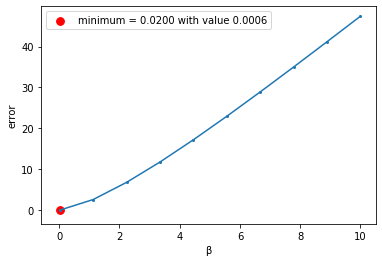

In [6]:
def error_FB_beta(beta):
    restored_signal = Foward_Backward(x_0, 1e-06, beta)
    error_beta = normalized_quadratic_error(restored_signal)
    return error_beta

Beta = np.linspace(0.02, 10, 10)
Error_FB = []
for beta in Beta :
    Error_FB.append(error_FB_beta(beta))

plt.plot(Beta, Error_FB, 'o-', markersize=2)
plt.xlabel('\u03B2')
plt.ylabel('error');

min_index = np.argmin(Error_FB)
minimum = Beta[min_index]
min_val = Error_FB[min_index]

plt.scatter(minimum, min_val, s= 60, c = 'red', label = 'minimum = {:5.4f} with value {:5.4f}'.format(minimum, min_val))
plt.legend();

#### Douglas Rachford algorithm

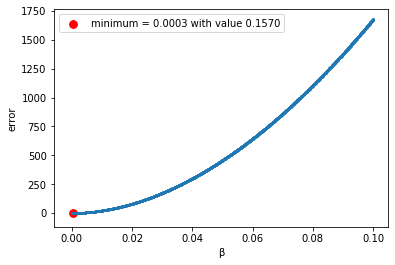

In [7]:
def error_DR_beta(beta):
    restored_signal = Douglas_Rachford(x_0, 1e-06, beta)
    error_beta = normalized_quadratic_error(restored_signal)
    return error_beta

Beta = np.linspace(0.0001, 0.1, 1000)
Error_DR = []
for beta in Beta :
    Error_DR.append(error_DR_beta(beta))

plt.plot(Beta, Error_DR, 'o-', markersize=2)
plt.xlabel('\u03B2')
plt.ylabel('error');

min_index = np.argmin(Error_DR)
minimum = Beta[min_index]
min_val = Error_DR[min_index]

plt.scatter(minimum, min_val, s= 60, c = 'red', label = 'minimum = {:5.4f} with value {:5.4f}'.format(minimum, min_val))
plt.legend();

For the best value $\beta = 0.0003$, we plot the restored signal.

error = 0.15700482 with Douglas Rachford Algorithm, β=0.0003


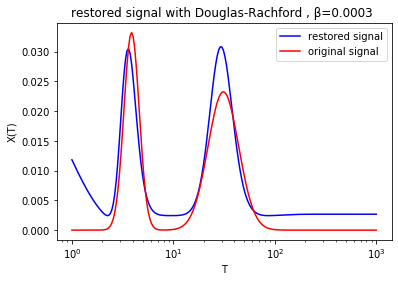

In [8]:
beta = 0.0003
x_0 = original_signal
restored_signal_DR = Douglas_Rachford(x_0, 1e-6, beta)
plt.plot(T, restored_signal_DR, 'b-', label='restored signal')
plt.plot(T, original_signal, 'r-', label='original signal')
plt.title('restored signal with Douglas-Rachford , \u03B2={} '.format(beta))
plt.legend()
plt.xscale('log')
plt.xlabel('T')
plt.ylabel('X(T)');

error = normalized_quadratic_error(restored_signal_DR)
print('error = {:9.8f} with Douglas Rachford Algorithm, \u03B2={}'.format(error, beta))

### 7. Compare the maximum entropy regularization with the ones proposed in the previous part in terms of reconstruction quality

Here we recap the errors obtained (with the best value of $\beta$ we could find) with different reconstruction strategies :
* Smoothness prior with solving linear system : error = 0.4927
* Smoothness prior + constrainst with projected gradient method : error = 0.0768
* Sparsity prior with Foward-Backward algorithm : error = 0.0024
* Entropy regularization with Foward-Backward algorithm : error =  0.0005
* Entropy regularization with Douglas-Rachford algorithm : error = 0.5450

The best results are still achieved by the Entropy regularization with Foward-Backward algorithm.

### 8. Changing the problem

We propose to use the PPXA+ method. Let : 
* $h_1(x) = \text{ent}(x) \in \Gamma_0(\mathbb{R}^N)$, $h_2(x) = \iota_{C}\in \Gamma_0(\mathbb{R}^M)$ where $C =\bar{\mathcal{B}}(y, \sqrt{\eta M}\sigma)$ is a closed convex non empty set.
* $L_1 = I$ and $L_2 = K$. 

Then the problem $$
\begin{align}
&\text{minimize}  & \text{ent}(x)&= \sum_{i=1}^N \phi(x_i) \\
&\text{subject to}  
  &\left\| Kx-y \right\|^2 &\leq \eta M \sigma^2 
\end{align}
$$

can be rewritten :
$$
\begin{align}
&\text{minimize}  & h_1\circ L_1(x) + h_2\circ L_2(x) & \\
& x \in \mathbb{R}^N  
\end{align}
$$

For the implementation, we will be needing : 
\begin{align*}\text{prox}_{\gamma h_2} (x) &= P_C(x) \\
&= \left \{ \begin{array}{l} \begin{array}{l l}
	x & \text{if } \Vert x- y \Vert \leq \sqrt{\eta M }\sigma \\
	y + \frac{x-y}{\Vert x-y\Vert} \sqrt{\eta M} \sigma & \text{ else }
\end{array} \end{array} \right. \\
& = y + (x-y) \min \left(1, \frac{ \sqrt{\eta M} \sigma }{\Vert x-y\Vert} \right)
\\ 
\text{prox}_{\gamma h_1}(x) &= \left(\gamma W \left( e^{-1 - \log(\gamma)+ \frac{x_n}{(\gamma)}}\right)\right)_{n\in [1, N]}\end{align*}

We set $\lambda_n  =1/2 $ for all $n \in \mathbb{N}$ and $\gamma =1$.

#### Implementation 

In [451]:
def prox_h_1(gamma, x):
    return gamma * np.real(lambertw(exp(x/gamma -1 - log(gamma))))
def prox_h_2(eta, x): 
    return y + (x-y)*min(1.0, np.sqrt(eta*M)*sigma/(np.sqrt((x-y).dot(x-y))))
    

def PPXA(x_0, eps, eta):
    
    lamb = 1.90
    gamma = 1
    x_1 = x_0
    x_2 = np.zeros(M)
    MATRIX = K_SQUARE + np.eye(N)
    v = linalg.solve(MATRIX,x_1+ K.T.dot(x_2))
    
    #MAX_ITER = int(1e6)
    MAX_ITER = int(1e5)
    for iteration in range(MAX_ITER):
        z_1 = prox_h_1(gamma, x_1)
        z_2 = prox_h_2(eta, x_2)
        c = linalg.solve(MATRIX,z_1+ K.T.dot(z_2))
        x_1 = x_1 + lamb*(2*c-v-z_1)
        #print(x_1)
        x_2 = x_2 + lamb*(K.dot(2*c-v)-z_2)
        v_next = v + lamb*(c-v)
        change_rate = relative_change(v, v_next)
        v = v_next
        
        if change_rate < eps:
            return v
        #if iteration%500 == 0:
            #print('iter = {}, err = {}'.format(iteration,change_rate))
            #print(np.sqrt(eta*M)*sigma/(np.sqrt((K.dot(v)-y).dot(K.dot(v)-y))))
    return v

error = 0.09345782 with PPXA Algorithm, eta=0.8


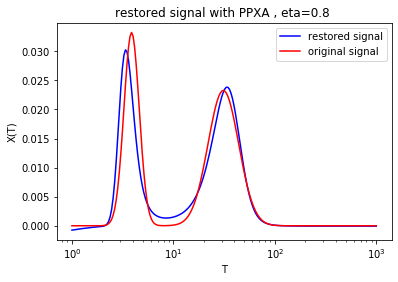

In [452]:
eta = 0.8
x_0 = original_signal
restored_signal_PPXA = PPXA(x_0, 1e-5, eta)
plt.plot(T, restored_signal_PPXA, 'b-', label='restored signal')
plt.plot(T, original_signal, 'r-', label='original signal')
plt.title('restored signal with PPXA , eta={} '.format(eta))
plt.legend()
plt.xscale('log')
plt.xlabel('T')
plt.ylabel('X(T)');

error = normalized_quadratic_error(restored_signal_PPXA)
print('error = {:9.8f} with PPXA Algorithm, eta={}'.format(error, eta))

#### Best value of $\eta$

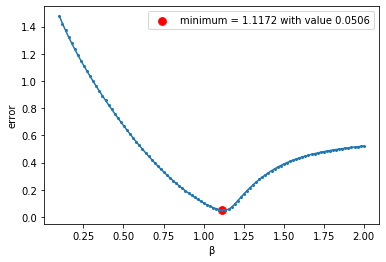

In [454]:
def error_PPXA_eta(eta):
    restored_signal = PPXA(x_0, 1e-06, eta)
    error_eta = normalized_quadratic_error(restored_signal)
    return error_eta

Eta = np.linspace(0.1, 2, 100)
Error_PPXA = []
for eta in Eta :
    Error_PPXA.append(error_PPXA_eta(eta))

plt.plot(Eta, Error_PPXA, 'o-', markersize=2)
plt.xlabel('\u03B2')
plt.ylabel('error');

min_index = np.argmin(Error_PPXA)
minimum = Eta[min_index]
min_val = Error_PPXA[min_index]

plt.scatter(minimum, min_val, s= 60, c = 'red', label = 'minimum = {:5.4f} with value {:5.4f}'.format(minimum, min_val))
plt.legend();

#### Best restoration

error = 0.05060234 with PPXA Algorithm, eta=1.1171717171717173


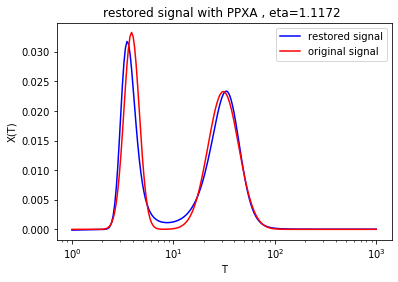

In [459]:
eta = minimum
x_0 = original_signal
restored_signal_PPXA = PPXA(x_0, 1e-6, eta)
plt.plot(T, restored_signal_PPXA, 'b-', label='restored signal')
plt.plot(T, original_signal, 'r-', label='original signal')
plt.title('restored signal with PPXA , eta={:6.5} '.format(eta))
plt.legend()
plt.xscale('log')
plt.xlabel('T')
plt.ylabel('X(T)');

error = normalized_quadratic_error(restored_signal_PPXA)
print('error = {:9.8f} with PPXA Algorithm, eta={}'.format(error, eta))

#### _Appendix_ Another method: Interior-point

The problem is equivalent to:
$$
\begin{align}
&\text{minimize}  & \text{ent}(x)&= \sum_{i=1}^N \phi(x_i) \\
&\text{subject to}    & -x & \preceq 0 \\
&  &\left\| Kx-y \right\|^2 -\eta M \sigma^2 &\preceq 0
\end{align}
$$

The objective function is convex and the inequality contraints are all convex. The objective is twice differentiable in the interior of $\{ -x \preceq 0\}$. So we can apply the **newton method with log-barrier**.

**_Remark_**: Effectively $ent$ is not differentiable in the boundary of feasible domain i.e. $x = 0$. But the interior point method will not go to the boundary.

**_Result_**: Unfortunately, the problem is not well posed for the interior point with log-barrier. Because the value of signal is too small near $0$ so that the hessian of _ent_ explodes and we cannot inverse this ill-conditionned hessian to get a newton descent step.

In [6]:
# eta = 1.1

def ent(x):
    return np.sum(x * np.log(x))

def grad_ent(x):
    return np.log(x) + 1

def hess_ent(x):
    return np.diag(1/x)

def g(eta, x):
    """Constraints function."""
    constraint = x @ MATRIX @ x - 2*x @ KY + Y_SQUARE - eta * M * sigma
    return np.append(-x, constraint)

def jac_g(x):
    constraint = 2*(K_SQUARE @ x - KY)
    return np.append(-np.eye(N), constraint[np.newaxis,:], 0)

def hess_g(x):
    return np.append(np.zeros((N,N,N)), 2*MATRIX[np.newaxis,:], 0)


In [21]:
#Notations in the Convex Optimization of S.Boyd

# import math
from functools import partial
# def mylog(x):
#     try:
#         return math.log(x)
#     except ValueError:
#         return -math.inf


def line_search(f,
                x: "starting point in the feasible domain of f",
                Delta_x: "descent direction",
                gradient_f_x: "gradient of f at x",
                a: "affinity of approximation" = 0.25,
                b: "decreasing rate" = 0.5
    ) -> "step size":
    """Backtracking line search in the Convex Optimization of S.Boyd page 464."""
    t = 1
    while f(x + t*Delta_x) > f(x) + a*t*gradient_f_x @ Delta_x:
        t = b*t
    return t

def newton_method(
        f: "convex function to be minimized",
        x: "starting point in the strictly feasible domain of f",
        e: "tolerance, >0",
        gradient_f,
        hessian_f,
        a: "line search parameter, affinity of approximation" = 0.25,
        b: "line search parameter, decreasing rate" = 0.5
    ) -> "argmin f":
    """Newton's method in the page 487"""
    while True:
        Grad_f_x = gradient_f(x)
        Hess_f_x = hessian_f(x)
        
#         breakpoint()
        newton_step = linalg.solve(Hess_f_x, Grad_f_x)
#         Hess_f_x_inv = np.linalg.inv(hessian_f(x))
        
        decrement = Grad_f_x @ newton_step
        if decrement/2 < e:
            return x
#         newton_step = -Hess_f_x_inv @ Grad_f_x
        newton_direction = - newton_step

        t = line_search(f, x, newton_direction, Grad_f_x, a, b)
        x = x + t*newton_direction
        
def barrier_inegality(
        f0: "Objective convex function to be minimized",
        g: "Inequality constranits convex vectorized function",
        grad_f0,
        hess_f0,
        jac_g,
        hess_g,
        x:  "strictly feasible starting point",
        e:  "tolerance, >0",
        t:  "t0 > 0" = 1,
        nu: "> 1" = 5
) -> "x* argmin with inequality constraints":   
    
    m = g(x).size
    
    def phi(x):
        return - np.sum(np.log(-g(x)))
    def grad_phi(x):
#         breakpoint()
        return jac_g(x).T @ (1/(-g(x)))
    def hess_phi(x):
        jacobian = jac_g(x)
        g_x = g(x)
        inv_g_square = (1/g_x**2)[:, np.newaxis]
        return jacobian.T @ (jacobian * inv_g_square) + np.tensordot(-1/g_x, hess_g(x), 1)
    
    while True:
        def f(t, x): return t * f0(x) + phi(x)
        def grad_f(t, x): return t* grad_f0(x) + grad_phi(x)
        def hess_f(t, x): return t* hess_f0(x) + hess_phi(x)
        x_star_t = newton_method(partial(f, t),
                                 x, e,
                                 partial(grad_f, t),
                                 partial(hess_f, t))

        x = x_star_t
        if m/t < e:
            return x
        t = nu * t

C:\Users\limen\Miniconda3\lib\site-packages\ipykernel_launcher.py:40: LinAlgWarning: Ill-conditioned matrix (rcond=1.84751e-44): result may not be accurate.
C:\Users\limen\Miniconda3\lib\site-packages\ipykernel_launcher.py:40: LinAlgWarning: Ill-conditioned matrix (rcond=1.55665e-44): result may not be accurate.
C:\Users\limen\Miniconda3\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in log
C:\Users\limen\Miniconda3\lib\site-packages\ipykernel_launcher.py:40: LinAlgWarning: Ill-conditioned matrix (rcond=2.85232e-44): result may not be accurate.
C:\Users\limen\Miniconda3\lib\site-packages\ipykernel_launcher.py:40: LinAlgWarning: Ill-conditioned matrix (rcond=5.19437e-44): result may not be accurate.
C:\Users\limen\Miniconda3\lib\site-packages\ipykernel_launcher.py:40: LinAlgWarning: Ill-conditioned matrix (rcond=6.25797e-44): result may not be accurate.
C:\Users\limen\Miniconda3\lib\site-packages\ipykernel_launcher.py:40: LinAlgWarning: Ill-conditi

ValueError: Precision not allowed in integer format specifier

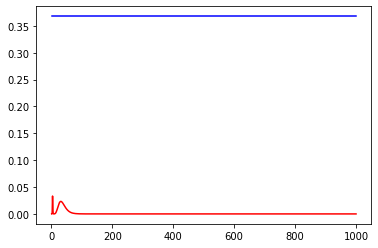

In [23]:
eta = 1.1

constraints = partial(g, eta)

x_0 = original_signal #1/100*np.ones(N)#
restored_signal_barrier = barrier_inegality(ent, constraints, grad_ent, hess_ent, jac_g, hess_g, x_0, 1e-06)
plt.plot(T, restored_signal_barrier, 'b-', label='restored signal')
plt.plot(T, original_signal, 'r-', label='original signal')
plt.title('restored signal with Barrier method , eta={:6.5} '.format(eta))
plt.legend()
plt.xscale('log')
plt.xlabel('T')
plt.ylabel('X(T)');

error = normalized_quadratic_error(restored_signal_barrier)
print('error = {:9.8f} with Barrier method, eta={}'.format(error, eta))